In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/content', train=True, download=True,
  transform=torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/content', train=False, download=True,
  transform=torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
  batch_size=batch_size_test, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
example_data.shape

torch.Size([1000, 1, 28, 28])

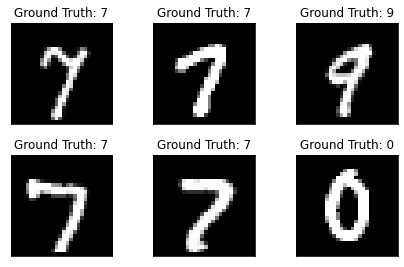

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [8]:
network = Net()
network.cuda()
optimizer = optim.SGD(network.parameters(), 
            lr=learning_rate,
            momentum=momentum)

In [9]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [10]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.cuda(), target.cuda()
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [11]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.cuda(), target.cuda()
      output = network(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [12]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


Test set: Avg. loss: 2.3062, Accuracy: 1166/10000 (12%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310409
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.210571
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.091017
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.832561
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.460787
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.850137
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.638499
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.872083
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.686774
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.369145
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.710647
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.590364
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.729150
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.505153
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.405763
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.480662
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.594730
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.601380
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.335180
Train Epoch: 1 [12160

Text(0, 0.5, 'negative log likelihood loss')

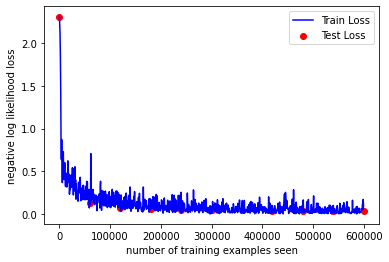

In [13]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [14]:
with torch.no_grad():
  output = network(example_data.cuda())

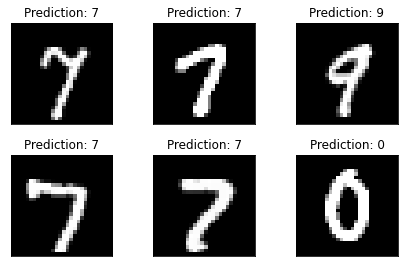

In [15]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

#Save and Load

In [16]:
torch.save(network.state_dict(), '/content/model.pth')
torch.save(optimizer.state_dict(), '/content/optimizer.pth')

In [17]:
continued_network = Net().cuda()
continued_optimizer = optim.SGD(network.parameters(), 
                 lr=learning_rate,
                 momentum=momentum)

In [18]:
network_state_dict = torch.load('/content/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('/content/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [19]:
from torchsummary import summary

summary(continued_network, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
           Dropout-3           [-1, 64, 12, 12]               0
            Linear-4                  [-1, 128]       1,179,776
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.52
Params size (MB): 4.58
Estimated Total Size (MB): 5.10
----------------------------------------------------------------
